<a href="https://colab.research.google.com/github/GeneSUN/time-series-analysis-toolkit/blob/main/Evaluating_Forecasts_%E2%80%93_Forecast_Metrics%08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install darts

In [2]:

# Download the script
!wget -O time_series_inspectors.py "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Analyzing%20and%20Visualizing/time_series_inspectors.py"

from time_series_inspectors import BaseTimeSeriesInspector, TrendInspector, SeasonalityInspector, HeteroscedasticityInspector

import warnings
warnings.filterwarnings('ignore')

--2025-09-25 02:18:31--  https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Analyzing%20and%20Visualizing/time_series_inspectors.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14631 (14K) [text/plain]
Saving to: ‘time_series_inspectors.py’

time_series_inspect 100%[===================>]  14.29K  --.-KB/s    in 0.001s  

2025-09-25 02:18:31 (19.7 MB/s) - ‘time_series_inspectors.py’ saved [14631/14631]




1. 📈 Plot Original Time Series

--- 🔍 Step: Visual Inspection ---
Purpose: Observe overall shape, amplitude, and possible patterns.



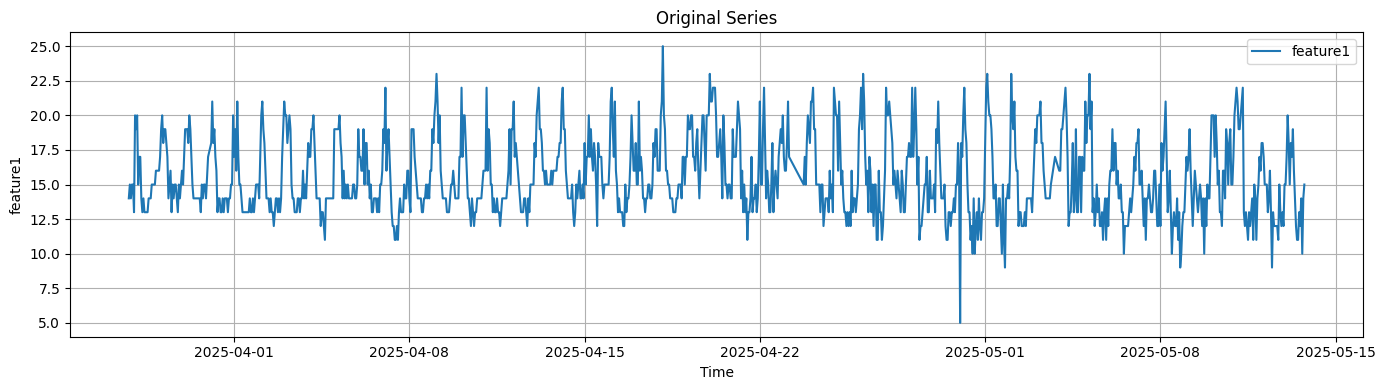

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/GeneSUN/time-series-analysis-toolkit/main/Data/df_cap_hour_pd.csv"
df_cap_hour_pd = pd.read_csv(url).rename(columns={'avg_4gsnr': 'feature1', 'avg_5gsnr': 'feature2'})\
                  .drop( columns =["feature2"]  )

base_inspector = BaseTimeSeriesInspector(df_cap_hour_pd, datetime_col='hour', value_col='feature1')
print("\n1. 📈 Plot Original Time Series")
base_inspector.plot_series()

In [13]:
df_cap_hour_pd

,sn,hour,feature1
0,ABB30701372,2025-03-27T19:00:00.000-04:00,14.0
1,ABB30701372,2025-03-27T20:00:00.000-04:00,15.0
2,ABB30701372,2025-03-27T21:00:00.000-04:00,14.0
3,ABB30701372,2025-03-27T22:00:00.000-04:00,15.0
4,ABB30701372,2025-03-27T23:00:00.000-04:00,15.0
...,...,...,...
1097,ABB30701372,2025-05-13T14:00:00.000-04:00,12.0
1098,ABB30701372,2025-05-13T15:00:00.000-04:00,14.0
1099,ABB30701372,2025-05-13T16:00:00.000-04:00,10.0
1100,ABB30701372,2025-05-13T17:00:00.000-04:00,14.0


In [4]:
#@title Coefficient of Variation
import numpy as np
import pandas as pd

def assess_forecastability(series, cutoff=0.49):
    """
    Assess the forecastability of a time series using Coefficient of Variation (CoV).

    Parameters
    ----------
    series : array-like or pandas Series
        The time series values.
    cutoff : float, default=0.49
        Rule-of-thumb cutoff to classify forecastability.

    Prints
    ------
    CoV value with interpretation.
    """

    # Convert to numpy
    values = np.asarray(series, dtype=float)

    # Mean and Std
    mu = np.mean(values)
    sigma = np.std(values, ddof=1)  # sample std

    # Handle zero mean (avoid division by zero)
    if mu == 0:
        print("⚠️ Mean of the series is 0 → CoV is undefined.")
        return None

    cov = sigma / mu

    print("📊 Forecastability Assessment")
    print(f"  • Mean (μ): {mu:.4f}")
    print(f"  • Std Dev (σ): {sigma:.4f}")
    print(f"  • Coefficient of Variation (CoV = σ/μ): {cov:.4f}")

    # Interpretation
    if cov < cutoff:
        print(f"✅ CoV < {cutoff}: This time series is relatively easier to forecast.")
    else:
        print(f"⚠️ CoV ≥ {cutoff}: This time series is harder to forecast.")

    # Caveats (from description)
    print("\n⚠️ Note: CoV does not account for trend, seasonality, or negative values.")
    return cov


In [7]:
res = assess_forecastability(df_cap_hour_pd[["feature1"]])


📊 Forecastability Assessment
  • Mean (μ): 15.5181
  • Std Dev (σ): 2.7617
  • Coefficient of Variation (CoV = σ/μ): 0.1780
✅ CoV < 0.49: This time series is relatively easier to forecast.

⚠️ Note: CoV does not account for trend, seasonality, or negative values.


In [8]:
#@title assess_forecastability_rv
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def assess_forecastability_rv(series, period, cutoff=0.49, model="additive"):
    """
    Assess the forecastability of a time series using Residual Variability (RV).

    Parameters
    ----------
    series : array-like or pandas Series
        The time series values.
    period : int
        Seasonal period for decomposition (e.g., 7 for weekly seasonality in daily data).
    cutoff : float, default=0.49
        Rule-of-thumb cutoff to classify forecastability.
    model : {"additive", "multiplicative"}
        Type of seasonal decomposition.

    Prints
    ------
    RV value with interpretation.
    """

    # Convert to pandas Series
    ts = pd.Series(series).dropna()

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(ts, period=period, model=model, extrapolate_trend="freq")
    residuals = decomposition.resid.dropna()

    # Mean of original series
    mu = ts.mean()

    # Std of residuals
    sigma_resid = residuals.std(ddof=1)

    if mu == 0:
        print("⚠️ Mean of original series is 0 → RV is undefined.")
        return None

    rv = sigma_resid / mu

    print("📊 Forecastability Assessment (Residual Variability - RV)")
    print(f"  • Mean of original series (μ): {mu:.4f}")
    print(f"  • Std Dev of residuals (σ_resid): {sigma_resid:.4f}")
    print(f"  • Residual Variability (RV = σ_resid / μ): {rv:.4f}")

    # Interpretation
    if rv < cutoff:
        print(f"✅ RV < {cutoff}: This time series is relatively easier to forecast.")
    else:
        print(f"⚠️ RV ≥ {cutoff}: This time series is harder to forecast.")

    # Caveats
    print("\n⚠️ Note: RV assumes trend & seasonality are predictable components.")
    print("   It isolates unpredictability in the residuals, unlike CoV.")
    return rv


In [ ]:
res = assess_forecastability_rv(df_cap_hour_pd["feature1"], period=24)

In [85]:
import pandas as pd
from prophet import Prophet
import numpy as np

# Make sure 'hour' is datetime and remove timezone
df_prophet = df_cap_hour_pd.rename(columns={"hour": "ds", "feature1": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])
df_prophet["ds"] = df_prophet["ds"].dt.tz_localize(None)


# Train/test split (70% train, 30% test)
split_idx = int(len(df_prophet) * 0.7)
train = df_prophet.iloc[:split_idx]
test = df_prophet.iloc[split_idx:]

# Define and fit Prophet model
m = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.add_seasonality(name="daily", period=24, fourier_order=5)  # 24-hour cycle
m.fit(train)

# Forecast for the test horizon
future = m.make_future_dataframe(periods=len(test), freq="H")
forecast = m.predict(future)

# Extract predictions aligned with the test set
y_true = test["y"].values
y_pred = forecast.iloc[-len(test):]["yhat"].values

# Compute SSE
sse = np.sum((y_true - y_pred) ** 2)
print("SSE on test set:", sse)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_drjmqhp/z8i2dq67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_drjmqhp/29iltsuz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29574', 'data', 'file=/tmp/tmp_drjmqhp/z8i2dq67.json', 'init=/tmp/tmp_drjmqhp/29iltsuz.json', 'output', 'file=/tmp/tmp_drjmqhp/prophet_modeln5kh2a01/prophet_model-20250925031624.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:16:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


SSE on test set: 3807.133088007034


In [83]:
df_cap_hour_pd[["hour","feature1"]]

,hour,feature1
0,2025-03-27T19:00:00.000-04:00,14.0
1,2025-03-27T20:00:00.000-04:00,15.0
2,2025-03-27T21:00:00.000-04:00,14.0
3,2025-03-27T22:00:00.000-04:00,15.0
4,2025-03-27T23:00:00.000-04:00,15.0
...,...,...
1097,2025-05-13T14:00:00.000-04:00,12.0
1098,2025-05-13T15:00:00.000-04:00,14.0
1099,2025-05-13T16:00:00.000-04:00,10.0
1100,2025-05-13T17:00:00.000-04:00,14.0
